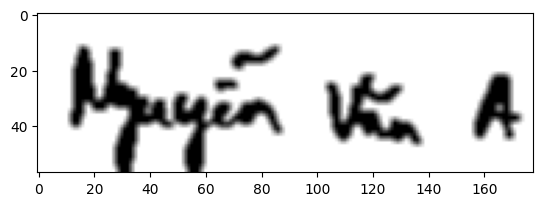

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image as pil
from PIL import Image
from pkg_resources import parse_version
if parse_version(pil.__version__)>=parse_version('10.0.0'):
    Image.ANTIALIAS=Image.LANCZOS

import warnings
warnings.filterwarnings("ignore")

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

def maximize_contrast(imgGrayscale):
	#Làm cho độ tương phản lớn nhất 
	height, width = imgGrayscale.shape[:2]
	
	imgTopHat = np.zeros((height, width, 1), np.uint8)
	imgBlackHat = np.zeros((height, width, 1), np.uint8)
	structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) #tạo bộ lọc kernel
	
	imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement, iterations = 5) #nổi bật chi tiết sáng trong nền tối
	#cv2.imwrite("tophat.jpg",imgTopHat)
	imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement, iterations = 15) #Nổi bật chi tiết tối trong nền sáng
	#cv2.imwrite("blackhat.jpg",imgBlackHat)
	imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat) 
	imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

	#Kết quả cuối là ảnh đã tăng độ tương phản 
	return imgGrayscalePlusTopHatMinusBlackHat

def remove_noise(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = maximize_contrast(img)

    _, blackAndWhite = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((2,3),np.uint8)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((2,3),np.uint8), iterations=1)
    blackAndWhite = cv2.erode(blackAndWhite, kernel, iterations=1)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((2,3),np.uint8), iterations=1)
    blackAndWhite = cv2.erode(blackAndWhite, kernel, iterations=1)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((1,2),np.uint8), iterations=1)

    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(blackAndWhite, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1] #get CC_STAT_AREA component
    img2 = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= 19:   #filter small dotted regions
            img2[labels == i + 1] = 255

    res = cv2.bitwise_not(img2)
    kernel1 = np.ones((2,2),np.uint8)
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel1)

    res = cv2.GaussianBlur(res,(3,3),2)

    return res

img = cv2.imread('img1.png')
img = remove_noise(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

21 giờ


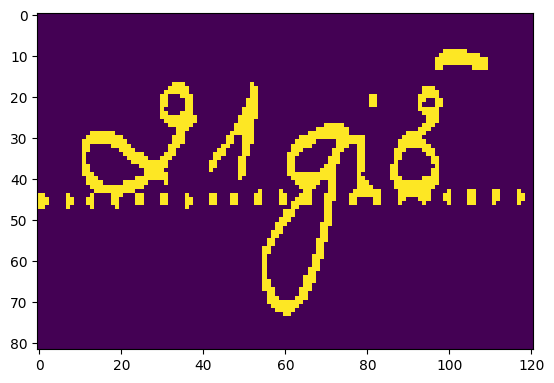

In [10]:
import cv2
import numpy as np
from PIL import Image as pil
from PIL import Image
from pkg_resources import parse_version
if parse_version(pil.__version__)>=parse_version('10.0.0'):
    Image.ANTIALIAS=Image.LANCZOS

import warnings
warnings.filterwarnings("ignore")

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

def maximize_contrast(imgGrayscale):
	#Làm cho độ tương phản lớn nhất 
	height, width = imgGrayscale.shape[:2]
	
	imgTopHat = np.zeros((height, width, 1), np.uint8)
	imgBlackHat = np.zeros((height, width, 1), np.uint8)
	structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) #tạo bộ lọc kernel
	
	imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement, iterations = 5) #nổi bật chi tiết sáng trong nền tối
	#cv2.imwrite("tophat.jpg",imgTopHat)
	imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement, iterations = 15) #Nổi bật chi tiết tối trong nền sáng
	#cv2.imwrite("blackhat.jpg",imgBlackHat)
	imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat) 
	imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

	#Kết quả cuối là ảnh đã tăng độ tương phản 
	return imgGrayscalePlusTopHatMinusBlackHat

def remove_noise(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = maximize_contrast(img)

    _, blackAndWhite = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((2,1),np.uint8), iterations=1)
    blackAndWhite = cv2.erode(blackAndWhite, np.ones((2,2),np.uint8), iterations=1)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((2,1),np.uint8), iterations=1)

    plt.imshow(blackAndWhite)

    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(blackAndWhite, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1] #get CC_STAT_AREA component
    img2 = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= 19:   #filter small dotted regions
            img2[labels == i + 1] = 255

    res = cv2.bitwise_not(img2)
    kernel1 = np.ones((2,2),np.uint8)
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel1)

    res = cv2.GaussianBlur(res,(3,3),2)

    return res

class OCRModel(object):
    def __init__(self, weight_path=None):
        if weight_path != None:
            self.weight_path = weight_path
        else:
            self.weight_path = "vietocr_model/weights/vgg_transformer_default.pth"

        # self.config = Cfg.load_config_from_name('vgg_transformer')
        self.config = Cfg.load_config_from_file('vietocr_model/config.yml')
        # self.config = Cfg.load_config_from_file('vietocr_model/config_vgg_seq2seq.yml')
        self.config['weights'] = self.weight_path
        self.config['cnn']['pretrained']=False
        self.config['device'] = 'cpu'
        self.config['predictor'].update({'beamsearch': True})

        self.detector = Predictor(self.config)

    def recognize(self, img):
        s = self.detector.predict(Image.fromarray(img), return_prob=False)
        return s



ocr = OCRModel("vietocr_model/weights/transformerocr_custom.pth")
# ocr = OCRModel("vietocr_model/weights/vgg_seq2seq.pth")
# ocr = OCRModel()
img = Image.open('img3.png')
img = remove_noise(np.array(img))
# plt.imshow(img)
s = ocr.recognize(np.array(img))
print(s)


(79, 76, 3)
0.9948367754830113
True


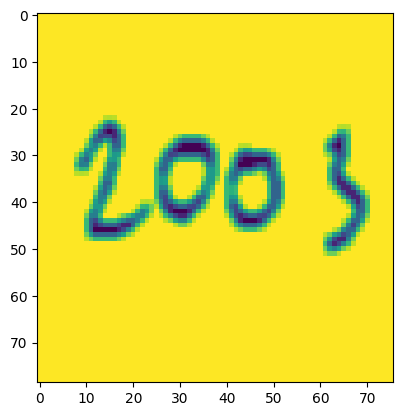

In [31]:
image = np.array(Image.open('img1.png'))
thresh = remove_noise(image)
# gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# _, thresh = cv2.threshold(gray_image, 245, 255, cv2.THRESH_BINARY)

# Đếm số điểm ảnh trắng trong ảnh
white_pixel_count = cv2.countNonZero(thresh)

# Tính tỉ lệ điểm ảnh trắng trên tổng số điểm ảnh
white_pixel_ratio = white_pixel_count / (image.shape[0] * image.shape[1])

# Xác định ngưỡng để xem ảnh có được coi là trắng hay không
threshold_ratio = 0.99
print(image.shape)
print(white_pixel_ratio)
print(white_pixel_ratio > threshold_ratio)
plt.imshow(thresh)

In [ ]:
import string
import unicodedata
import editdistance


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [ ]:
import os
import pathlib
RAW_FOLDER = pathlib.Path("/home/krystal/LearnSpace/LVTN/Data/Processing/data-extract/data0").absolute()
TEST_FOLDER = os.path.join(RAW_FOLDER, "test_line")
TEST_JSON = os.path.join(RAW_FOLDER, "test_line.json")
TEST_JSON

In [ ]:
import json
# open these label jsons files
with open(TEST_JSON, 'r', encoding='utf8') as f:
    test_labels = json.load(f)
# tesr_labels

In [ ]:
dict_filepath_label={}
raw_data_path = pathlib.Path(os.path.join(TEST_FOLDER))
for item in raw_data_path.glob('**/*.*'):
    file_name=str(os.path.basename(item))
    if (file_name != "labels.json"):
        label = test_labels[file_name]
        dict_filepath_label[str(item)]=label
all_image_paths = list(dict_filepath_label.keys())

In [ ]:
test_orig_txt = []
pred = []
for test_img_path in all_image_paths:
    img = cv2.imread(test_img_path)
    img = remove_noise(img)
    s = ocr.recognize(img)
    pred.append(s)
    label = dict_filepath_label[test_img_path]
    test_orig_txt.append(label)

In [ ]:
evaluate = ocr_metrics( predicts=pred,
                        ground_truth=test_orig_txt,
                        norm_accentuation=False,
                        norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])
print(e_corpus)